In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/satyakapardibudi/Downloads/archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/Users/satyakapardibudi/Downloads/archive/abc.html
/Users/satyakapardibudi/Downloads/archive/Train_Inpatientdata-1542865627584.csv
/Users/satyakapardibudi/Downloads/archive/Train_Outpatientdata-1542865627584.csv
/Users/satyakapardibudi/Downloads/archive/.DS_Store
/Users/satyakapardibudi/Downloads/archive/Train-1542865627584.csv
/Users/satyakapardibudi/Downloads/archive/Train_Beneficiarydata-1542865627584.csv


In [7]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
plt.style.use('ggplot')

In [10]:
def read_data(tp = "Train", N = 1542865627584):
    target = pd.read_csv("/Users/satyakapardibudi/Downloads/archive/Train-1542865627584.csv".format(tp.title(), N))
    pt = pd.read_csv("/Users/satyakapardibudi/Downloads/archive/Train_Beneficiarydata-1542865627584.csv".format(tp.title(), N))
    in_pt = pd.read_csv("/Users/satyakapardibudi/Downloads/archive/Train_Inpatientdata-1542865627584.csv".format(tp.title(), N))
    out_pt = pd.read_csv("/Users/satyakapardibudi/Downloads/archive/Train_Outpatientdata-1542865627584.csv".format(tp.title(), N))
    return (in_pt, out_pt, pt, target)

In [11]:
### Load Train data
in_pt, out_pt, asl, target = read_data()

In [12]:
asl = asl.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 0)
asl = asl.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

In [13]:
print(asl.shape)
asl.head()

(138556, 25)


BeneID         DOB  DOD  Gender  Race  RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                      0     39   
1  BENE11002  1936-09-01  NaN       0     1                      0     39   
2  BENE11003  1936-08-01  NaN       1     1                      0     52   
3  BENE11004  1922-07-01  NaN       1     1                      0     39   
4  BENE11005  1935-09-01  NaN       1     1                      0     24   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       0                     0                          0   
2                       0                     0                          1   
3                       0                     1                          1   
4                       0                     1                          0   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         1                                1   
4                         0                                0   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   0                         0                      0   
2                   0                         0                      0   
3                   0                         0                      0   
4                   0                         0                      0   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  
0                        60                     70  
1                        30                     50  
2                        90                     40  
3                      1810                    760  
4                      1790                   1200  

[5 rows x 25 columns]

In [14]:
print(target.shape)
target.head()

(5410, 2)


Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes
2  PRV51004             No
3  PRV51005            Yes
4  PRV51007             No

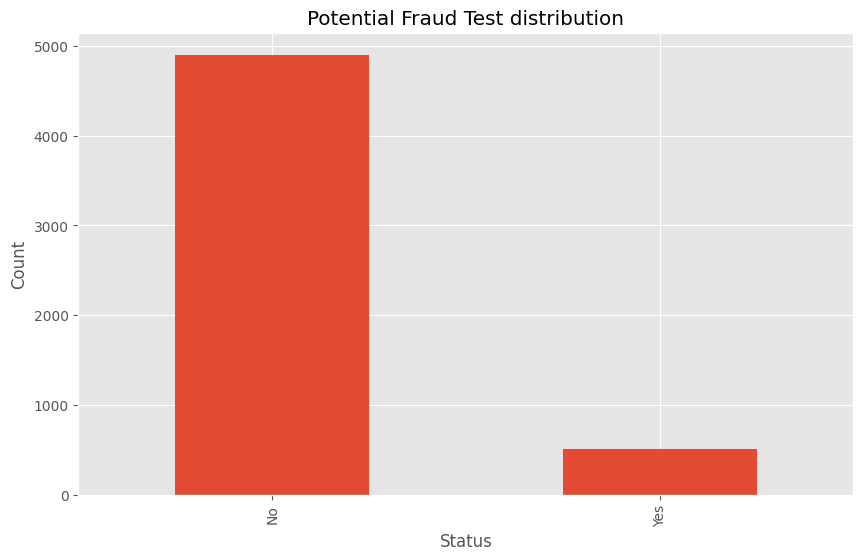

In [15]:
plt.title("Potential Fraud Test distribution")
target.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [16]:
print(in_pt.shape)
in_pt.head()

(40474, 30)


BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11014  CLM63689   2009-08-13  2009-08-30  PRV56614   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   
2                    5000          PHY372395                NaN   
3                    5000          PHY369659          PHY392961   
4                   10000          PHY379376          PHY398258   

  OtherPhysician AdmissionDt  ... ClmDiagnosisCode_7  ClmDiagnosisCode_8  \
0            NaN  2009-04-12  ...               2724               19889   
1            NaN  2009-08-31  ...                NaN                 NaN   
2      PHY324689  2009-09-17  ...                NaN                 NaN   
3      PHY349768  2009-02-14  ...              25062               40390   
4            NaN  2009-08-13  ...               5119               29620   

  ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1  \
0               5849                 NaN                NaN   
1                NaN                 NaN             7092.0   
2                NaN                 NaN                NaN   
3               4019                 NaN              331.0   
4              20300                 NaN             3893.0   

  ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  ClmProcedureCode_6  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 30 columns]

In [17]:
print(out_pt.shape)
out_pt.head()

(517737, 27)


BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2  BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3  BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4  BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                      30          PHY326117                NaN   
1                      80          PHY362868                NaN   
2                      10          PHY328821                NaN   
3                      40          PHY334319                NaN   
4                     200          PHY403831                NaN   

  OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0            NaN              78943  ...                NaN   
1            NaN               6115  ...                NaN   
2            NaN               2723  ...                NaN   
3            NaN              71988  ...                NaN   
4            NaN              82382  ...                NaN   

  ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   

  ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  DeductibleAmtPaid  ClmAdmitDiagnosisCode  
0                 0                  56409  
1                 0                  79380  
2                 0                    NaN  
3                 0                    NaN  
4                 0                  71947  

[5 rows x 27 columns]

In [18]:
#Adding Features and Combining Data Sets
#(1)   Add Flag column 'WhetherDead' using DOD values to tell whether beneficiary is dead on not

In [19]:
asl['WhetherDead']= 0
asl.loc[asl.DOD.notna(),'WhetherDead'] = 1

In [20]:
#(1)   Adding Target numeric variable.

In [21]:
target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 

In [22]:
#(1)   Combine Inpatient and Outpatient datasets

In [23]:
MediCare = pd.merge(in_pt, out_pt, left_on = [ x for x in out_pt.columns if x in in_pt.columns], right_on = [ x for x in out_pt.columns if x in in_pt.columns], how = 'outer')
MediCare.shape

(558211, 30)

In [24]:
#(1)   Add Patients information

In [25]:
data = pd.merge(MediCare, asl,left_on='BeneID',right_on='BeneID',how='inner')
data.shape

(558211, 55)

In [26]:
# Create a new variable "NumPhysicians" with number of physians(from 0 to 3): 'AttendingPhysician' not missing + 'OperatingPhysician' not missing + 'OtherPhysician' not missing

In [27]:
### Check Physicians columns for stange records and value length.
def len_check(data , l):
    S = dict()
    for i in data.columns:
         S[i] = [x for x in data.loc[ np.any(data[[i]].notnull().to_numpy(), axis = 1)][i].unique() if (len(str(x)) < l | len(str(x)) > l ) ]
    
    print(S)

len_check(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']], len('PHY388358')) 

{'AttendingPhysician': [], 'OperatingPhysician': [], 'OtherPhysician': []}


In [28]:
def uniq(a):
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in a.values])

In [29]:
### Create new variable and drop 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'
data['NumPhysicians'] = uniq(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 
data = data.drop(['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'], axis = 1)

In [30]:
#(1)   Count number of procedures 'NumProc' for each claim.

In [31]:
ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]
### Create new variable 
data['NumProc'] = data[ClmProcedure_vars].notnull().to_numpy().sum(axis = 1)

In [32]:
keep = ['BeneID', 'ClaimID', 'ClmAdmitDiagnosisCode', 'NumProc' ] + ClmProcedure_vars
### Checking if procedures is unique
print(data[keep].loc[data['NumProc'] != uniq( data[ClmProcedure_vars])])

data = data.drop(ClmProcedure_vars, axis = 1)

Empty DataFrame
Columns: [BeneID, ClaimID, ClmAdmitDiagnosisCode, NumProc, ClmProcedureCode_1, ClmProcedureCode_2, ClmProcedureCode_3, ClmProcedureCode_4, ClmProcedureCode_5, ClmProcedureCode_6]
Index: []


In [33]:
#(1)   Count number of claims, extra reported claims and unique.

In [34]:
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]

### Create new variable 
data['NumClaims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)

In [35]:
keep = ['BeneID', 'ClaimID', 'ClmAdmitDiagnosisCode', 'NumClaims'] + ClmDiagnosisCode_vars

### Create new variable 
data['NumClaims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)

print(data[keep].loc[data['NumClaims'] != uniq( data[ClmDiagnosisCode_vars])].head())
### if checking result of unique claims is not missing, we are going to add number of unique claims.

       BeneID    ClaimID ClmAdmitDiagnosisCode  NumClaims  \
1   BENE11001   CLM66048                  6186          4   
35  BENE11037  CLM283913                 42731          2   
38  BENE11041   CLM54944                 49121          7   
39  BENE11041   CLM78682                 51881         10   
70  BENE11066   CLM75192                 59971         10   

   ClmAdmitDiagnosisCode ClmDiagnosisCode_1 ClmDiagnosisCode_2  \
1                   6186               6186               2948   
35                 42731              42731                NaN   
38                 49121              49121               2752   
39                 51881              51881               2859   
70                 59971               5990              78829   

   ClmDiagnosisCode_3 ClmDiagnosisCode_4 ClmDiagnosisCode_5  \
1               56400                NaN                NaN   
35                NaN                NaN                NaN   
38               7812              71690       

In [36]:
data['NumUniqueClaims'] = uniq(data[ClmDiagnosisCode_vars])

data['ExtraClm'] = data['NumClaims'] - data['NumUniqueClaims']

data = data.drop(ClmDiagnosisCode_vars, axis = 1)
data = data.drop(['NumClaims'], axis = 1)

In [37]:
#(1)   Convert Dates and calculate days for Claim and for Admission. Calculate patient age at time of claim.

In [38]:
### 
data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')

data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')

data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')

### Number of hospitalization days
data['AdmissionDays'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1
### Number of claim days 
data['ClaimDays'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1

data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)

In [39]:
#(1)   Hospitalization flag 'Hospt'

In [40]:
data['Hospt'] = np.where(data.DiagnosisGroupCode.notnull(), 1, 0)
data = data.drop(['DiagnosisGroupCode'], axis = 1)

In [41]:
### Check if there were any actions after death. 
data['DeadActions'] = np.where(np.any(np.array([ data[x] > data['DOD'] for x in ['AdmissionDt', 'DischargeDt', 'ClaimStartDt', 'ClaimEndDt']]), axis = 0), 1, 0)

print(data.loc[data['DeadActions'] > 0])

### If there is no actions after death date, we will drop this variable. 
data = data.drop(['AdmissionDt', 'DeadActions', 'DischargeDt', 'ClaimStartDt', 'ClaimEndDt', 'DOD', 'DOB'], axis = 1)

Empty DataFrame
Columns: [BeneID, ClaimID, ClaimStartDt, ClaimEndDt, Provider, InscClaimAmtReimbursed, AdmissionDt, DeductibleAmtPaid, DischargeDt, DOB, DOD, Gender, Race, RenalDiseaseIndicator, State, County, NoOfMonths_PartACov, NoOfMonths_PartBCov, ChronicCond_Alzheimer, ChronicCond_Heartfailure, ChronicCond_KidneyDisease, ChronicCond_Cancer, ChronicCond_ObstrPulmonary, ChronicCond_Depression, ChronicCond_Diabetes, ChronicCond_IschemicHeart, ChronicCond_Osteoporasis, ChronicCond_rheumatoidarthritis, ChronicCond_stroke, IPAnnualReimbursementAmt, IPAnnualDeductibleAmt, OPAnnualReimbursementAmt, OPAnnualDeductibleAmt, WhetherDead, NumPhysicians, NumProc, NumUniqueClaims, ExtraClm, AdmissionDays, ClaimDays, Age, Hospt, DeadActions]
Index: []

[0 rows x 43 columns]


In [43]:
#Stats

In [44]:
data.describe(exclude = ['object'])

InscClaimAmtReimbursed  DeductibleAmtPaid         Gender  \
count           558211.000000      557312.000000  558211.000000   
mean               997.012133          78.421085       0.421162   
std               3821.534891         274.016812       0.493746   
min                  0.000000           0.000000       0.000000   
25%                 40.000000           0.000000       0.000000   
50%                 80.000000           0.000000       0.000000   
75%                300.000000           0.000000       1.000000   
max             125000.000000        1068.000000       1.000000   

                Race  RenalDiseaseIndicator          State         County  \
count  558211.000000          558211.000000  558211.000000  558211.000000   
mean        1.255011               0.196786      25.446969     378.588195   
std         0.717437               0.397569      15.192784     265.215531   
min         1.000000               0.000000       1.000000       0.000000   
25%         1.000000               0.000000      11.000000     150.000000   
50%         1.000000               0.000000      24.000000     350.000000   
75%         1.000000               0.000000      38.000000     570.000000   
max         5.000000               1.000000      54.000000     999.000000   

       NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  ...  \
count        558211.000000         558211.00000          558211.000000  ...   
mean             11.931472             11.93877               0.401868  ...   
std               0.889712              0.78590               0.490276  ...   
min               0.000000              0.00000               0.000000  ...   
25%              12.000000             12.00000               0.000000  ...   
50%              12.000000             12.00000               0.000000  ...   
75%              12.000000             12.00000               1.000000  ...   
max              12.000000             12.00000               1.000000  ...   

       OPAnnualDeductibleAmt    WhetherDead  NumPhysicians        NumProc  \
count          558211.000000  558211.000000  558211.000000  558211.000000   
mean              649.698745       0.007400       1.292981       0.053557   
std              1002.020811       0.085707       0.505266       0.280534   
min                 0.000000       0.000000       0.000000       0.000000   
25%               120.000000       0.000000       1.000000       0.000000   
50%               340.000000       0.000000       1.000000       0.000000   
75%               790.000000       0.000000       2.000000       0.000000   
max             13840.000000       1.000000       3.000000       5.000000   

       NumUniqueClaims       ExtraClm  AdmissionDays      ClaimDays  \
count    558211.000000  558211.000000   40474.000000  558211.000000   
mean          3.239150       0.033117       6.665168       2.727940   
std           2.570114       0.178991       5.638538       4.904984   
min           0.000000       0.000000       1.000000       1.000000   
25%           1.000000       0.000000       3.000000       1.000000   
50%           2.000000       0.000000       5.000000       1.000000   
75%           4.000000       0.000000       8.000000       1.000000   
max          11.000000       2.000000      36.000000      37.000000   

                 Age          Hospt  
count  558211.000000  558211.000000  
mean       73.301277       0.072507  
std        13.021602       0.259325  
min        25.000000       0.000000  
25%        68.000000       0.000000  
50%        74.000000       0.000000  
75%        82.000000       0.000000  
max       101.000000       1.000000  

[8 rows x 33 columns]

In [45]:
data.shape

(558211, 36)

In [47]:
#Checking and Inpute missing records

In [48]:
data.isnull().sum()

BeneID                                  0
ClaimID                                 0
Provider                                0
InscClaimAmtReimbursed                  0
DeductibleAmtPaid                     899
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt          

In [49]:
## Fill missing results using 0
data = data.fillna(0).copy()
data.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'WhetherDead', 'NumPhysicians', 'NumProc',
       'NumUniqueClaims', 'ExtraClm', 'AdmissionDays', 'ClaimDays', 'Age',
       'Hospt'],
      dtype='object')

In [50]:
# Group by provider each column

In [51]:
### Sum all results
df1 = data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                  'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                                                  'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                  'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                  'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                  'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                  'ChronicCond_stroke', 'WhetherDead', 'NumPhysicians', 
                                                  'NumProc','NumUniqueClaims', 'ExtraClm', 'AdmissionDays',
                                                  'ClaimDays', 'Hospt']].sum()
### Count number of records
df2 = data[['BeneID', 'ClaimID']].groupby(data['Provider']).nunique().reset_index()
### Calculate mean
df3 = data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                    'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age']].mean()
### Combine all together
df = df2.merge(df1, on='Provider', how='left').merge(df3, on='Provider', how='left')
print(df.shape, target.shape)

(5410, 32) (5410, 3)


In [52]:
# ML for Fraud Detection

In [53]:
df1 = df.merge(target, on='Provider', how='left').drop(['Provider', 'target'], axis = 1)
df2 = df.merge(target, on='Provider', how='left').drop(['Provider', 'PotentialFraud'], axis = 1)
print(df.shape, target.shape)

(5410, 32) (5410, 3)


In [54]:
g = sns.pairplot(df1, hue = 'PotentialFraud', markers="+")
g.fig.suptitle('Plot pairwise relationships in a dataset')
plt.show()

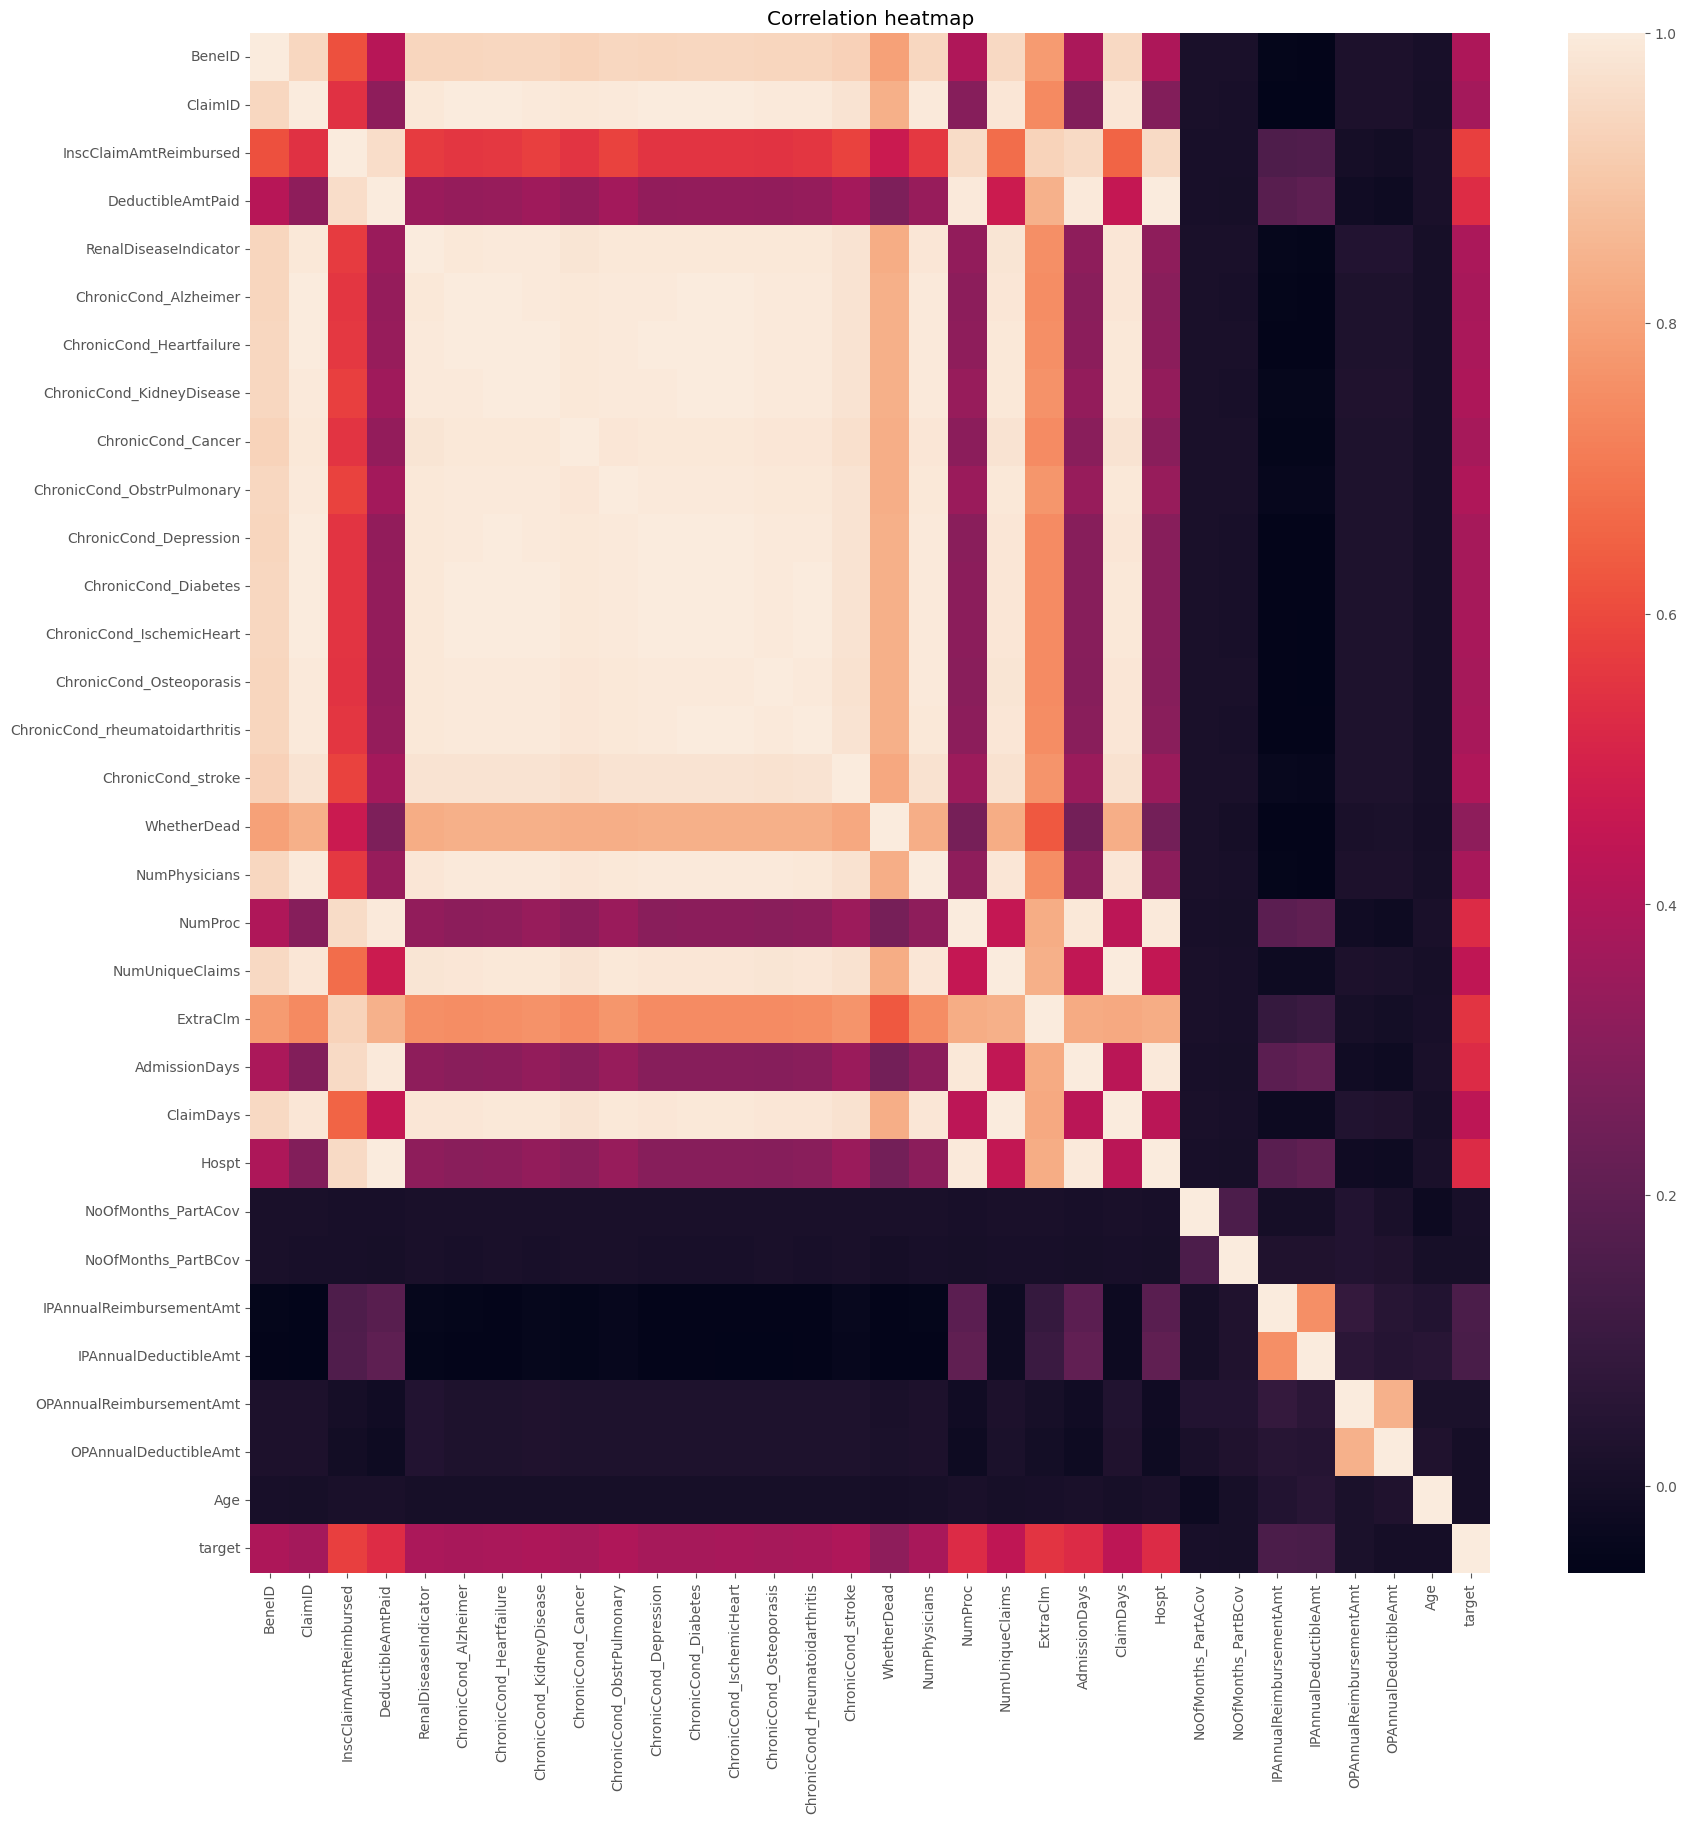

In [55]:
plt.figure(figsize=(20, 20))
plt.title('Correlation heatmap')
sns.heatmap(df2.corr())
plt.show()

In [56]:
countFraud = target.target.value_counts()
print('No:', countFraud[0])
print('Yes:', countFraud[1])
print('Proportion:', round(countFraud[1] / countFraud[0], 2))
### We should keep in mind that we are using unbalanced data

No: 4904
Yes: 506
Proportion: 0.1


In [57]:
# Splitting the data

In [58]:
### Only Train dataset is labeled that why we split it to two sets train and validation
X_train, X_val, y_train, y_val = train_test_split(df.drop(['Provider'], axis = 1), target.target.to_numpy(), test_size=0.25, random_state=1)

cols = X_train.columns

X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)

print("Train obs: {}; Features Number: {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation obs: {};".format(X_val.shape[0]))

Train obs: 4057; Features Number: 31
Validation obs: 1353;


In [59]:
## write Master Learn class which we are going to use for our analysis
class MasterL:
    
    def __init__(self, model, #### model is a method which we are going to use for detecting FRAUDS. For example: sklearn.svm
                 X= X_train, y= y_train, test= X_val, ### data
                 **kvars  #### additional key parameters for model
                ):
        self.clf = model( **kvars)
        self.methodname = model.__name__
        self.X_train = X
        self.y_train = y
        self.X_test = test
        self.fit(self.X_train, self.y_train)
        self.predicted = self.predict(test)
        
    def fit (self, X, y):
        self.clf.fit(X, y)
    
    def predict(self, x):
        return self.clf.predict(x)
       
    def get_score(self, y = y_val, roc = True, params = False):
        accuracy = accuracy_score(self.predicted, y)
        if params:
            print(self.clf.get_params())
        print(self.methodname+ " metrics:\n")
        print(" Accuracy Score: %.2f%%" % (accuracy * 100.0))
        print(" Confusion matrix:", "\n",confusion_matrix(y_true=y, y_pred=self.predicted))
        print( 'Classification report:\n', classification_report(y, self.predicted))
        if roc:
            print(" ROC Score: %.2f%%" % (roc_auc_score(y, self.clf.predict_proba(self.X_test)[:,1])))
        
    def plot_curves(self, y = y_val):   
        plt.figure(figsize=(17, 5))
        plt.subplot(131)
        # Plot the recall precision tradeoff        
        self.plot_pr_curve(y)
        plt.subplot(132)        
        self.plot_lern_curve(accuracy_score)     
        plt.subplot(133)
        self.plot_lern_curve(roc_auc_score)
        plt.show()
        
    def plot_pr_curve(self, y = y_val):
        
        plt.subplot(122)
        # Calculate average precision and the PR curve
        average_precision = average_precision_score(y, self.predicted)

        # Obtain precision and recall 
        precision, recall, _ = precision_recall_curve(y, self.clf.predict_proba(self.X_test)[:,1])
        
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision))
    
    def plot_lern_curve(self, metrics):
        plt.title(self.methodname + " Learning Curves")
        plt.xlabel("Training examples")
        plt.ylabel("{}".format(' '.join(metrics.__name__.split('_')).title()))
        
        train_sizes, train_scores, test_scores = learning_curve(self.clf, self.X_train, self.y_train, n_jobs=-1, 
                                                                cv = ShuffleSplit(n_splits=5, test_size=.25 , random_state = 5), 
                                                                train_sizes=np.linspace(0.5, 1.0, 10), scoring = make_scorer(metrics))
        train_scores_mean = np.mean(train_scores, axis=1) 
        test_scores_mean = np.mean(test_scores, axis=1) 
        #plt.grid()

        plt.plot(train_sizes,  train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes,  test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.legend(loc="best")
    
    def plot_roc_curve(self, y = y_val, models = None, fig = None):
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(121)
        
        self.roc_curves(ax, y, models)
        
        ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        
        plt.legend(loc="best")
        
        #if fig != None:
            #plt.savefig( fig, bbox_inches = 'tight')
       
    def roc_curves(self, p, y, M):
        if M == None:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
        else:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
            for i in M:
                fpr, tpr, thresholds = roc_curve(y, i.clf.predict_proba(i.X_test)[:,1] )
                p.plot(fpr, tpr,  label=i.methodname )

#### Function for serching best parameters which is fiting the model and shows best results for specified method.               
def grid(method, parameters):
    
    grid_1 = GridSearchCV(method, parameters, scoring = make_scorer(accuracy_score), cv=5, n_jobs = -1)
    grid_2 = GridSearchCV(method, parameters, scoring = make_scorer(roc_auc_score), cv=5, n_jobs = -1)
    
    grid_1.fit(X_train, y_train)
    print('Best parameters using accuracy score:')
    print(grid_1.best_params_)

    grid_2.fit(X_train, y_train)
    print('Best parameters usin ROC accuracy score:')
    print(grid_2.best_params_)

In [60]:
# Logistic Regression
#Grid Seach best Parametes for Log-reg L2 regularization

In [61]:
parameters = { 
        'C' : np.linspace(0.001, 1.0, 1000)
}

grid(LogisticRegression(solver= 'liblinear', class_weight='balanced', random_state = 5), parameters)

Best parameters using accuracy score:
{'C': 0.14400000000000002}
Best parameters usin ROC accuracy score:
{'C': 0.09}


In [62]:
# Grid Seach best Parametes for Log-reg L1 regularization

In [63]:
parameters = { 
        'C' : np.linspace(0.001, 1.0, 1000)
}

grid(LogisticRegression(penalty = 'l1', solver= 'liblinear', class_weight='balanced', random_state = 5), parameters)

Best parameters using accuracy score:
{'C': 0.008}
Best parameters usin ROC accuracy score:
{'C': 0.004}


In [64]:
### Logistic regression 
### Balanced Weight and Scaled data
ML1 = MasterL(LogisticRegression, 
              penalty= 'l1',
              solver= 'liblinear', class_weight='balanced', random_state = 5 , C = 0.001)
# Get your performance metrics
ML1.get_score()

LogisticRegression metrics:

 Accuracy Score: 83.74%
 Confusion matrix: 
 [[1023  210]
 [  10  110]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1233
           1       0.34      0.92      0.50       120

    accuracy                           0.84      1353
   macro avg       0.67      0.87      0.70      1353
weighted avg       0.93      0.84      0.87      1353

 ROC Score: 0.94%


In [65]:
# Plot Validation Results

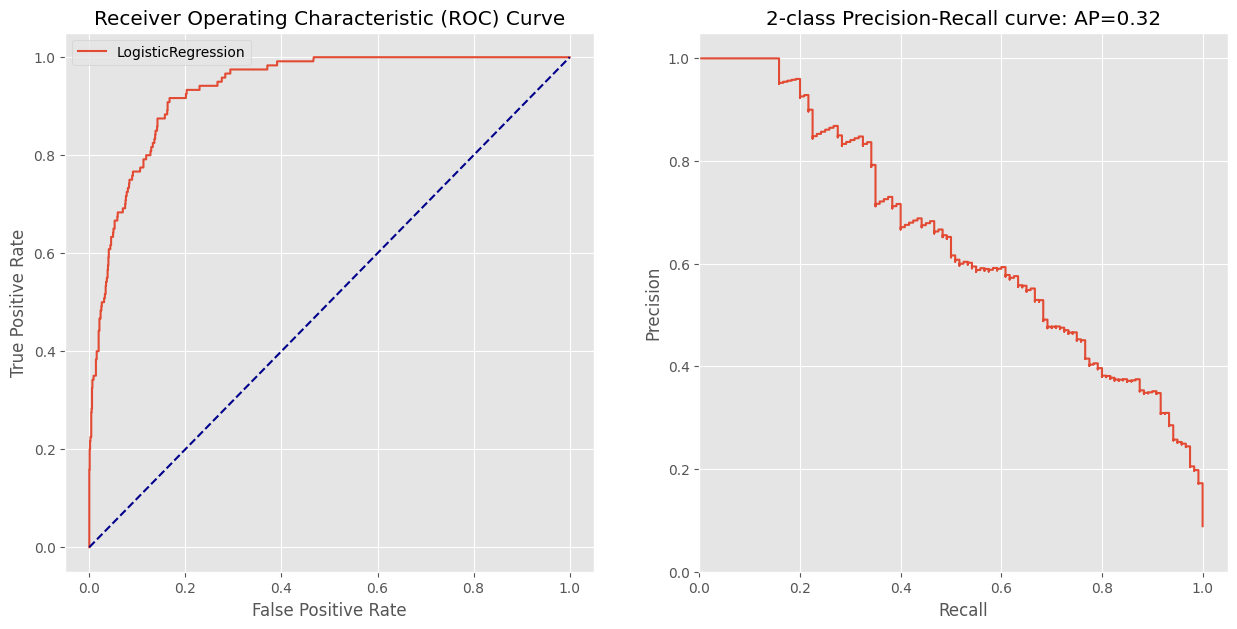

In [66]:
ML1.plot_roc_curve()
ML1.plot_pr_curve()

In [67]:
#   2. Support Vector Machines(SVM)

In [68]:
# Grid Seach best Parametes for SVM

In [69]:
parameters = { 
        #'gamma' : np.linspace(0.01, .1, 5),
        'C' : np.linspace(0.1, 1.0, 10)
}

grid(SVC( gamma = 'auto', probability = True, random_state= 5, class_weight= 'balanced'), parameters)

Best parameters using accuracy score:
{'C': 1.0}
Best parameters usin ROC accuracy score:
{'C': 0.4}


In [70]:
# SVM(scaled data)
ML2 = MasterL(SVC, 
              gamma = 'auto', probability = True, random_state= 5, class_weight= 'balanced', C=1 )

# Get your performance metrics
ML2.get_score()

SVC metrics:

 Accuracy Score: 85.07%
 Confusion matrix: 
 [[1046  187]
 [  15  105]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1233
           1       0.36      0.88      0.51       120

    accuracy                           0.85      1353
   macro avg       0.67      0.86      0.71      1353
weighted avg       0.93      0.85      0.88      1353

 ROC Score: 0.92%


In [71]:
# Plot Validation Results

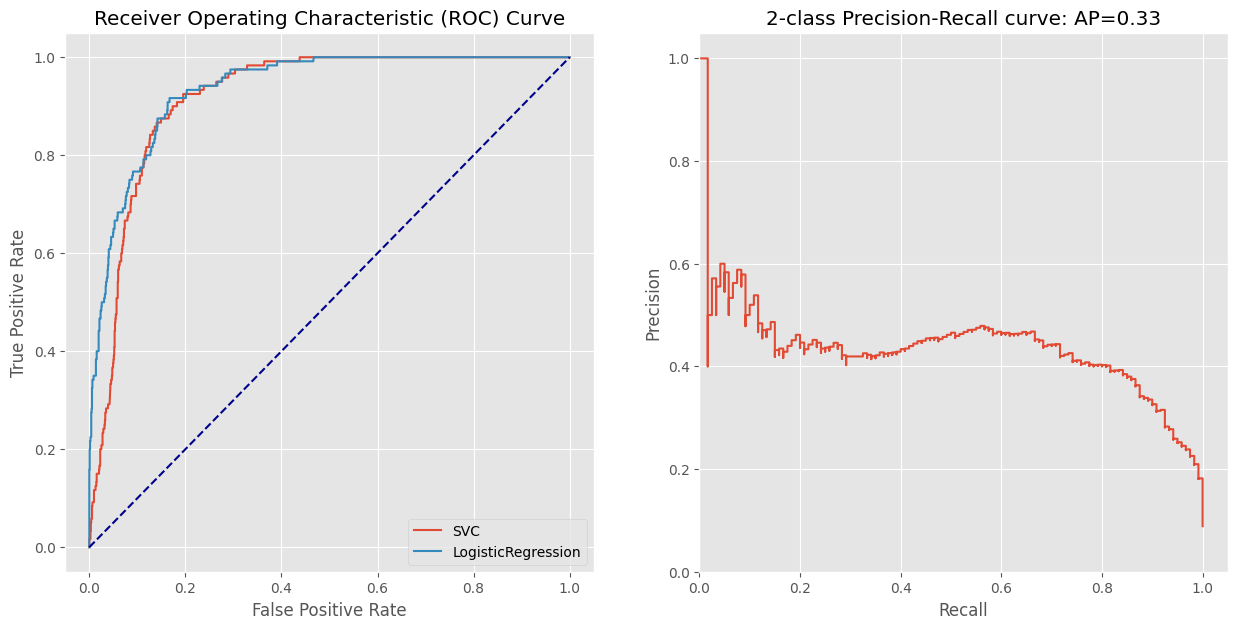

In [72]:
ML2.plot_roc_curve(models = [ML1])
ML2.plot_pr_curve()

In [73]:
# 3. Random Forest Clasifier

In [74]:
# Search for best parameters

In [75]:
kf = KFold(n_splits=5)
est = np.linspace(10, 200, 39)

RandFo = dict() 
def kind_GridSearchCV(i):
    acScore = list()
    rocScore = list()    
    for train_index, test_index in kf.split(X_train):
        Xtrain, Xtest = X_train[train_index], X_train[test_index]
        ytrain, ytest = y_train[train_index], y_train[test_index]
        RandFo[i] = RandomForestClassifier(n_estimators =  i, n_jobs = -1, random_state = 5, 
                                           class_weight = 'balanced_subsample', min_samples_split = 0.25 )
        RandFo[i].fit(Xtrain, ytrain)
        acScore.append(accuracy_score(RandFo[i].predict(X_val), y_val))
        rocScore.append(roc_auc_score(y_val, RandFo[i].predict_proba(X_val)[:,1]))

    return  [ i, np.mean(acScore), np.mean(rocScore) ]

scores = list()
for i in est:
    scores.append(kind_GridSearchCV(int(i)))

scoresD = pd.DataFrame(scores, columns = ['N_est', 'Accuracy', "ROC accuracy"])

print(scoresD.sort_values(by=['Accuracy'], ascending=False).iloc[0])
print(scoresD.sort_values(by=["ROC accuracy"], ascending=False).iloc[0])

N_est           25.000000
Accuracy         0.787435
ROC accuracy     0.917292
Name: 3, dtype: float64
N_est           80.000000
Accuracy         0.782114
ROC accuracy     0.922405
Name: 14, dtype: float64


In [76]:
### Random Forest Clasifier
# Continue fitting the model and obtain predictions

ML3 = MasterL(RandomForestClassifier, 
              n_estimators = 60, n_jobs = -1, random_state = 5, class_weight = 'balanced_subsample', 
              min_samples_split = 0.25
             )
 
# Get your performance metrics
ML3.get_score() 

RandomForestClassifier metrics:

 Accuracy Score: 78.42%
 Confusion matrix: 
 [[950 283]
 [  9 111]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      1233
           1       0.28      0.93      0.43       120

    accuracy                           0.78      1353
   macro avg       0.64      0.85      0.65      1353
weighted avg       0.93      0.78      0.83      1353

 ROC Score: 0.92%


In [77]:
# Plot Validation Results

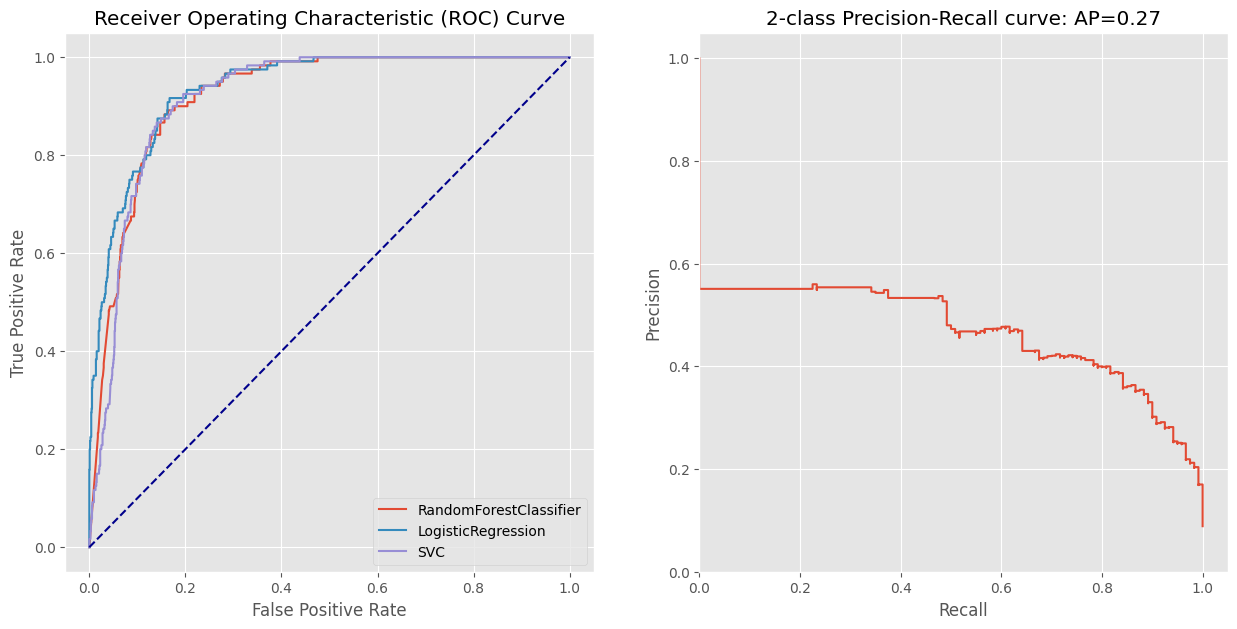

In [78]:
ML3.plot_roc_curve(models = [ML1, ML2])
ML3.plot_pr_curve()

In [79]:
# Top highest scoring Random Forest Features

In [80]:
features = ML3.clf.feature_importances_
Features_score = pd.DataFrame(np.array([cols, features]).T, columns = ["VarName", "Importamce"]).sort_values(by=["Importamce"], ascending=False)

Features_score.head()

VarName Importamce
21           AdmissionDays   0.159161
2   InscClaimAmtReimbursed   0.140527
3        DeductibleAmtPaid   0.113984
20                ExtraClm   0.105328
18                 NumProc   0.080645

In [81]:
# 4. Ensemble method clasifier (log-reg + Random Forest)

In [82]:
### Generate ensemble
ML4 = MasterL(VotingClassifier, 
              estimators=[ ('lr', ML1.clf), ("rf", ML3.clf)], voting='soft', n_jobs = -1
             )
 
# Get your performance metrics
ML4.get_score()

VotingClassifier metrics:

 Accuracy Score: 78.71%
 Confusion matrix: 
 [[954 279]
 [  9 111]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      1233
           1       0.28      0.93      0.44       120

    accuracy                           0.79      1353
   macro avg       0.64      0.85      0.65      1353
weighted avg       0.93      0.79      0.83      1353

 ROC Score: 0.93%


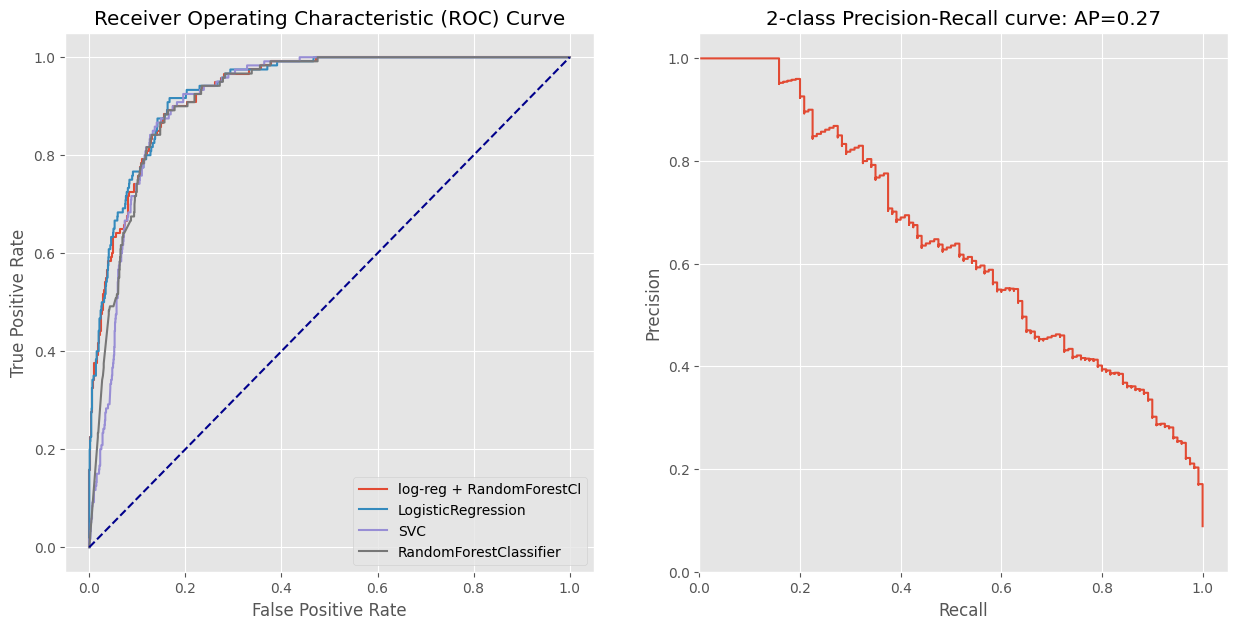

In [83]:
ML4.methodname = "log-reg + RandomForestCl"
ML4.plot_roc_curve(models = [ML1, ML2, ML3])
ML4.plot_pr_curve()